# Análisis Lavado de Gases KKK

En este notebook se implementa un algoritmo que
- Identifica los escalones de lavados de gases desde el punto de vista de las variables del ventilador KKK
- Recorta el inicio y fin del escalon de modo que captura solo la parte donde el ventilador esta activo (partida, regimen y parada)
- Se analiza la parte de la senal donde la velocidad es contante para obtener un comportamiento historico del ventilador y para hallar eventuales quiebres en la tendencia.
- Se separa la parada del ventilador y se cuantifica su decrecimmiento exponentecial

La tabla de análisis tiene las siguientes columnas
- número de lavado (dentro del intervalo considerado)
- tiempo de inicio y fin
- duración
Regimen
- valor rpm
- duracion regimen
- promedio y varianza vibracion
- promedio y flujo
- valor final del nivel de vibracion en regimen (comienzo de las vibraciones libres)
Parada
- se genera un indicador entre rpm y amplitud vibratoria aun no definido representativo


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
def ObtenerQuery(path_tag):
    df_taglist = pd.read_excel(path_tag, usecols=range(0,1), engine = 'openpyxl')
    query = df_taglist[df_taglist.columns[0]].values.tolist()
    return query

In [3]:
import pandas as pd

import sys
sys.path.insert(0, 'C:/Users/MLuser/Documents/Paquetes Python Desarrollados/')
from tzchile.tzchile import reconocer_tz, TimestampChile, transformar_utc_a_tzchile, transformar_utc_a_tzchile_naive
sys.path.insert(0, '')

In [23]:
def ActualizarListaTagsPI(query):
    import pandas as pd
    import PIconnect as PI
    from PIconnect.PIConsts import CalculationBasis, SummaryType
    #df_taglist = pd.read_excel(path_tag, usecols=range(0,1), engine = 'openpyxl')
    #query = df_taglist.values.tolist()
    df_tags = pd.DataFrame()
#    with PI.PIServer() as server:
    with PI.PIServer(server='192.168.62.43', username='dquezada', password='dquezada', authentication_mode=1, domain=None, timeout=None) as server:
        tags = server.search(query)
        for tag in tags:
            try:
                d = {'tag': tag.name, 
                     'description': tag.description, 
                     'uom': tag.units_of_measurement, 
                     'avg_1w': round(tag.summary('*-7d','*',SummaryType.AVERAGE, calculation_basis=CalculationBasis.EVENT_WEIGHTED).values[0][0],2),
                     'count_h': int(1/(24*7)*tag.summary('*-7d','*',SummaryType.COUNT, calculation_basis=CalculationBasis.EVENT_WEIGHTED).values[0][0])
                     }
            except:
                d = {'tag': tag.name, 
                     'description': tag.description, 
                     'uom': tag.units_of_measurement, 
                     'avg_1w': round(tag.summary('*-7d','*',SummaryType.AVERAGE, calculation_basis=CalculationBasis.TIME_WEIGHTED).values[0][0],2),
                     'count_h': int(1/(24*7)*tag.summary('*-7d','*',SummaryType.COUNT, calculation_basis=CalculationBasis.EVENT_WEIGHTED).values[0][0])
                     }
            df_tags_temp = pd.DataFrame(data = d, index = [0])
            df_tags = pd.concat([df_tags, df_tags_temp], ignore_index = True)
            
    return df_tags

In [24]:
def get_tag_name(tag_description, df_tags_info):
    tag_name = df_tags_info.loc[df_tags_info['description'] == tag_description, 'tag'].iloc[0]
    return tag_name

## Carga

In [25]:
#path_tag = 'D:/BASES DE DATOS PI/taglist/taglist_horno_lbr_refractario.xlsx'
path_tag = "C:/Users/MLuser/Documents/analisis aumento de vibraciones kkk/taglist_init_kkk_vibraciones.xlsx"

#path_tag = 'C:/Users/MLuser/Documents/Datasets Fijos/20230128_analisis enfriamiento ah2/compiled/interpolated/5s/2019_12-2023_06.csv'
#df_taglist = pd.read_excel(path_tag, usecols=range(0,1), engine = 'openpyxl')
#df_taglist[df_taglist.columns[0]].values.tolist()

In [26]:
query = ObtenerQuery(path_tag)
print(query)

['CVG.VDF_KKK_P_OUT', 'CVG.VDF_KKK_RPM', 'CVG.VT_112.1', 'CVG.VT_112.1_FILT', 'CVG.VT_112.2', 'CVG.VT_112.2_FILT', 'CVG.FT_053', 'CVG.M_VEL_1H', 'CVG.M_VEL_2H', 'CVG.M_VEL_3H', 'CVG.M_VEL_4H']


In [22]:
df_tags2

,tag,description,uom,avg_1w,count_h
0,CVG.M_VEL_1H,Modulo de Velocidad Punto 1H Motor Lado Libre,mm/s,3.97,711


In [11]:
#path_data = 'C:/Users/MLuser/Documents/Datasets Fijos/20230128_analisis enfriamiento ah2/2022_52.csv'

path_data = "C:/Users/MLuser/Documents/analisis aumento de vibraciones kkk/data/2017_01-2023_11.csv"
length = pd.read_csv(path_data, usecols=[0])
length = length.values.shape[0]

In [12]:
print(length)

39191364


In [13]:
chunk_size = 10000
total = np.ceil(length/chunk_size)

In [14]:
df_chunks = pd.read_csv(path_data, chunksize = chunk_size)

In [ ]:
df = pd.DataFrame()
pbar = tqdm(total=total)
for chunk in df_chunks:
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], errors = 'coerce')
    chunk.set_index('Timestamp', inplace = True)
    #chunk.index = chunk.index.map(lambda x: x.replace(tzinfo = None))
#    chunk.index = chunk.index.map(lambda x: transformar_utc_a_tzchile_naive(x))
    df = pd.concat([df,chunk])
    pbar.update(1)

In [ ]:
pbar.clear()
pbar.close()

In [261]:
df

,CVG.VDF_KKK_P_OUT,CVG.VDF_KKK_RPM,CVG.VT_112.1,CVG.VT_112.1_FILT,CVG.VT_112.2,CVG.VT_112.2_FILT,CVG.FT_053,CVG.M_VEL_1H,CVG.M_VEL_2H,CVG.M_VEL_3H,CVG.M_VEL_4H
Timestamp,,,,,,,,,,,
2019-05-06 13:53:20,1599,1485,12.7097,No Data,7.61556,No Data,175995,20.93799,1.0506,Over Range,2.04398
2019-05-06 13:53:25,1587,1485,13.5906,No Data,8.13891,No Data,173060,20.93799,1.0506,Over Range,2.04398
2019-05-06 13:53:30,1564,1485,12.7481,No Data,7.8126,No Data,169116,10.27352,0.971028,Over Range,1.95062
2019-05-06 13:53:35,1542,1485,12.7562,No Data,7.83267,No Data,165174,7.951598,0.953703,Over Range,1.9303
2019-05-06 13:53:40,1526,1485,12.501,No Data,7.80387,No Data,161231,7.951598,0.953703,Over Range,1.9303
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19 23:59:40,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
2023-03-19 23:59:45,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
2023-03-19 23:59:50,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data


In [262]:
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors = 'coerce')

In [263]:
df2 = pd.DataFrame(df.loc[df['CVG.VDF_KKK_RPM'] > 120])
df2['Timedelta'] = [np.nan] + list(df2.index.values[1:] - df2.index.values[0:-1])
df2['Timedelta'] = df2['Timedelta'].apply(lambda x: x.seconds)

df2['Inicio Lavado']  = (df2['Timedelta'] > 60)
df2['Nro Lavado'] = df2['Inicio Lavado'].cumsum()
df2.head(5)

,CVG.VDF_KKK_P_OUT,CVG.VDF_KKK_RPM,CVG.VT_112.1,CVG.VT_112.1_FILT,CVG.VT_112.2,CVG.VT_112.2_FILT,CVG.FT_053,CVG.M_VEL_1H,CVG.M_VEL_2H,CVG.M_VEL_3H,CVG.M_VEL_4H,Timedelta,Inicio Lavado,Nro Lavado
Timestamp,,,,,,,,,,,,,,
2019-05-06 13:53:20,1599.0,1485.0,12.70968,NaN,7.615560,NaN,175995.2,20.937990,1.050600,NaN,2.043977,NaN,False,0
2019-05-06 13:53:25,1587.0,1485.0,13.59061,NaN,8.138913,NaN,173059.5,20.937990,1.050600,NaN,2.043977,5.0,False,0
2019-05-06 13:53:30,1564.0,1485.0,12.74806,NaN,7.812604,NaN,169116.5,10.273520,0.971028,NaN,1.950622,5.0,False,0
2019-05-06 13:53:35,1542.0,1485.0,12.75624,NaN,7.832674,NaN,165173.5,7.951598,0.953703,NaN,1.930296,5.0,False,0
2019-05-06 13:53:40,1526.0,1485.0,12.50101,NaN,7.803867,NaN,161230.6,7.951598,0.953703,NaN,1.930296,5.0,False,0


## Acumulación de los lavados en el tiempo

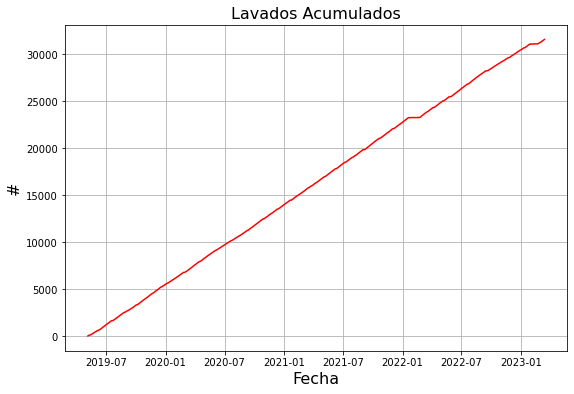

In [264]:
fig = plt.figure(figsize=(9,6))
plt.title(f'Lavados Acumulados', fontsize=16)
plt.plot(df2['Nro Lavado'], color='red', marker = '')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('#', fontsize=16)
plt.grid()
plt.show()

### Visualización de un perfil de lavado específico

Un perfil de lavado tiene 

- Una partida rápidado
- Un estado de regimen dond e

In [266]:
#n_perfil = 5501
#tag_selected = 'AH2.PI_LT_SN2'
#tag_selected_2 = 'AH2.PI_LT_SS2'
#perfil_series = df2.loc[df2['Nro Carga'] == n_perfil, tag_selected].iloc[10:-10]
#perfil_series_2 = df2.loc[df2['Nro Carga'] == n_perfil, tag_selected_2].iloc[10:-10]
#date_selected_start = str(df2.loc[df2['Nro Carga'] == n_perfil].index.min())
#date_selected_finish = str(df2.loc[df2['Nro Carga'] == n_perfil].index.max())

In [294]:
from tqdm import tqdm

lista_lavados = list(pd.unique(df2['Nro Lavado']))#[-100:]#[1:-1]#[-8000:]
tag_selected = 'CVG.VT_112.1'
tag_selected_2 = 'CVG.VDF_KKK_RPM'
tag_selected_3 = 'CVG.FT_053'
lista_tuples_lavados = []

In [ ]:
import scipy.stats

In [ ]:
for i in tqdm(range(len(lista_lavados))):
    n_lavado = lista_lavados[i]
    try:

        duracion_timestamp = (df2.loc[df2['Nro Lavado'] == n_lavado].index.max() - df2.loc[df2['Nro Lavado'] == n_lavado].index.min()).seconds*1/60

        perfil_series = df2.loc[df2['Nro Lavado'] == n_lavado, tag_selected]#.iloc[10:-10]
        perfil_series_2 = df2.loc[df2['Nro Lavado'] == n_lavado, tag_selected_2]#.iloc[10:-10]
        perfil_series_3 = df2.loc[df2['Nro Lavado'] == n_lavado, tag_selected_3]#.iloc[10:-10]    

        date_selected_start = str(df2.loc[df2['Nro Lavado'] == n_lavado].index.min())
        date_selected_finish = str(df2.loc[df2['Nro Lavado'] == n_lavado].index.max())

        rpm_perfil = perfil_series_2.mode().iloc[0]

        df_reg_perfil = df2.loc[(df2['Nro Lavado'] == n_lavado)&(df2['CVG.VDF_KKK_RPM'] == rpm_perfil)].copy()
        t_reg_1 = df_reg_perfil.index[0]
        t_reg_2 = df_reg_perfil.index[-1]

        date_selected_on = str(t_reg_1)
        date_selected_off = str(t_reg_2)

        vib_1_mean = df_reg_perfil['CVG.VT_112.1'].mean()
        vib_1_std = df_reg_perfil['CVG.VT_112.1'].std()
        vib_2_mean = df_reg_perfil['CVG.VT_112.2'].mean()
        vib_2_std = df_reg_perfil['CVG.VT_112.2'].std()

        vib_1h_mean = df_reg_perfil['CVG.M_VEL_1H'].mean()
        vib_1h_std = df_reg_perfil['CVG.M_VEL_1H'].std()
        vib_2h_mean = df_reg_perfil['CVG.M_VEL_2H'].mean()
        vib_2h_std = df_reg_perfil['CVG.M_VEL_2H'].std()
        vib_3h_mean = df_reg_perfil['CVG.M_VEL_3H'].mean()
        vib_3h_std = df_reg_perfil['CVG.M_VEL_3H'].std()        
        vib_4h_mean = df_reg_perfil['CVG.M_VEL_4H'].mean()
        vib_4h_std = df_reg_perfil['CVG.M_VEL_4H'].std()
        
        
        flow_mean = df_reg_perfil['CVG.FT_053'].mean()
        flow_std = df_reg_perfil['CVG.FT_053'].std()

        perfil_parada = df2.loc[(df2['Nro Lavado'] == n_lavado)&(df2.index > t_reg_2), tag_selected]
        perfil_parada_2 = df2.loc[(df2['Nro Lavado'] == n_lavado)&(df2.index > t_reg_2), tag_selected_2]

        x_n = 18/60*perfil_parada_2.values
        y_n = perfil_parada.values

        poly, residuals, rank, singular_values, rcond = np.polyfit(x_n, y_n, deg=2, full = True)
        y_int = [np.polyval(poly,elem) for elem in x_n]
        perfil_calculado = pd.Series(y_int, index = perfil_parada.index)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(perfil_parada.values, perfil_calculado.values)

        list_n = tuple([n_lavado, date_selected_start, date_selected_on, date_selected_off, date_selected_finish, duracion_timestamp,rpm_perfil,vib_1_mean,vib_2_mean,vib_1h_mean,vib_2h_mean,vib_3h_mean,vib_4h_mean,flow_mean,vib_1_std,vib_2_std,vib_1h_std,vib_2h_std,vib_3h_std,vib_4h_std,flow_std,slope, intercept, r_value, p_value, std_err] + list(poly))
    #        perfil_series_2 = df2.loc[df2['Nro Lavado'] == n_lavado, tag_selected_2].iloc[10:-10]
    #        x_n_2 = np.arange(0,5*len(perfil_series_2)/60,5/60)
    #        y_n_2 = perfil_series_2.values
    #        poly_2, residuals_2, rank_2, singular_values_2, rcond_2 = np.polyfit(x_n_2, y_n_2, deg=2, full = True)
    #        y_int_2 = [np.polyval(poly_2,elem) for elem in x_n_2]
    #        perfil_calculado_2 = pd.Series(y_int_2, index = perfil_series_2.index)
    #        slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = scipy.stats.linregress(perfil_series_2.values, perfil_calculado_2.values)
    #        poly2_2 = np.polyder(poly_2, m = 2)
    #        list_n_2 = tuple(list(poly_2) + [r_value_2, std_err_2] +  list(poly2_2))
        tuple_n = tuple(list_n)
        lista_tuples_lavados.append(tuple_n)
    except:
        pass

  1%|▋                                                                           | 301/31580 [01:42<3:02:37,  2.85it/s]

In [141]:
[n_lavado, date_selected_start, date_selected_on, date_selected_off, date_selected_finish, duracion_timestamp,vib_1_mean,vib_2_mean,flow_mean,vib_1_std,vib_2_std,flow_std,slope, intercept, r_value, p_value, std_err]

[31508,
 '2023-03-10 16:10:45',
 '2023-03-10 16:12:00',
 '2023-03-10 16:15:15',
 '2023-03-10 16:19:35',
 8.833333333333334,
 23.7298015,
 16.00210625,
 202355.33500000002,
 0.387837525415952,
 0.3006597426488613,
 1044.0164367873024,
 0.9676927359752425,
 0.34280201725434445,
 0.9837137469687216,
 6.160856693637127e-39,
 0.02500540130291555]

In [ ]:
df2

In [142]:
list(poly)

[0.00030968597545614606, -0.10842499262430971, 13.118711187351511]

Consultas

- La velocidad de regimen siempre ha sido constante 1450???
- En que lugar se encuentra la frecuencia de la fuerza de excitación con respecto a 

In [272]:
#df_consolidado =  pd.DataFrame(lista_tuples_lavados, columns = ['nro_carga','inicio','fin', 'duracion','a2_sn','a1_sn','a0_sn','r_value_sn','std_err_sn','c0_sn','a2_ss','a1_ss','a0_ss','r_value_ss','std_err_ss','c0_ss'])
#df_consolidado =  pd.DataFrame(lista_tuples_lavados, columns = ['nro_lavado','inicio', 'entrada_regimen','salida_regimen','fin' ,'duracion'])

df_consolidado =  pd.DataFrame(lista_tuples_lavados, columns = ['n_lavado', 'date_selected_start', 'date_selected_on', 'date_selected_off', 'date_selected_finish', 'duracion_timestamp','rpm_perfil','vib_1_mean','vib_2_mean','vib_1h_mean','vib_2h_mean','vib_3h_mean','vib_4h_mean','flow_mean','vib_1_std','vib_2_std','vib_1h_std','vib_2h_std','vib_3h_std','vib_4h_std','flow_std','slope', 'intercept', 'r_value', 'p_value', 'std_err','a2','a1','a0'])
df_consolidado.index = pd.to_datetime(df_consolidado['date_selected_start'], errors = 'coerce')
df_consolidado.head(10)

,n_lavado,date_selected_start,date_selected_on,date_selected_off,date_selected_finish,duracion_timestamp,rpm_perfil,vib_1_mean,vib_2_mean,vib_1h_mean,...,vib_4h_std,flow_std,slope,intercept,r_value,p_value,std_err,a2,a1,a0
date_selected_start,,,,,,,,,,,,,,,,,,,,,
2019-05-06 13:53:20,0,2019-05-06 13:53:20,2019-05-06 13:53:20,2019-05-06 14:27:35,2019-05-06 14:33:25,40.083333,1485.0,12.331561,7.527151,6.054817,...,0.192211,10757.640439,0.913581,0.417002,0.955814,7.043805e-38,0.034074,0.000097,-0.023425,3.482068
2019-05-06 15:57:50,1,2019-05-06 15:57:50,2019-05-06 15:58:55,2019-05-06 16:28:30,2019-05-06 16:34:05,36.250000,1485.0,10.998796,6.667322,3.253885,...,0.279212,8602.777835,0.903481,0.463023,0.950516,1.035180e-34,0.036628,0.000076,-0.016101,3.225984
2019-05-06 16:44:20,2,2019-05-06 16:44:20,2019-05-06 16:45:40,2019-05-06 17:30:50,2019-05-06 17:36:35,52.250000,1485.0,12.343553,7.478319,5.799098,...,0.180719,10090.668350,0.920648,0.414385,0.959504,1.379766e-38,0.033021,0.000099,-0.022913,3.592270
2019-05-06 17:46:50,3,2019-05-06 17:46:50,2019-05-06 17:48:00,2019-05-06 18:18:25,2019-05-06 18:24:05,37.250000,1485.0,12.755871,7.686582,10.061131,...,0.259862,11365.864102,0.898657,0.542936,0.947975,1.600517e-34,0.037147,0.000104,-0.024566,3.829443
2019-05-06 18:59:30,4,2019-05-06 18:59:30,2019-05-06 19:00:55,2019-05-06 19:24:25,2019-05-06 19:30:10,30.666667,1485.0,13.081992,7.891386,6.984690,...,0.243260,9784.849085,0.899653,0.570958,0.948500,3.630797e-35,0.036707,0.000075,-0.011106,3.014747
2019-05-06 19:35:25,5,2019-05-06 19:35:25,2019-05-06 19:36:35,2019-05-06 21:20:10,2019-05-06 21:25:55,110.500000,1485.0,13.413018,8.453610,7.385697,...,0.225832,10266.869351,0.890951,0.584187,0.943902,5.915150e-34,0.038080,0.000083,-0.016230,3.325238
2019-05-06 21:35:30,6,2019-05-06 21:35:30,2019-05-06 21:36:45,2019-05-06 22:16:45,2019-05-06 22:22:30,47.000000,1485.0,13.684938,8.530150,5.828420,...,0.324291,10399.204068,0.883250,0.649006,0.939814,5.840948e-33,0.039231,0.000125,-0.033418,4.428075
2019-05-06 22:37:30,7,2019-05-06 22:37:30,2019-05-06 22:38:35,2019-05-06 23:14:15,2019-05-06 23:19:55,42.416667,1485.0,12.958084,7.954074,3.365488,...,0.280286,8544.722298,0.905571,0.551837,0.951615,1.548315e-35,0.035995,0.000065,-0.007028,2.833771
2019-05-06 23:41:25,8,2019-05-06 23:41:25,2019-05-06 23:42:35,2019-05-07 00:16:55,2019-05-07 00:22:40,41.250000,1485.0,14.949868,9.451883,5.120610,...,0.364606,9777.254461,0.876035,0.672480,0.935967,4.371597e-32,0.040260,0.000114,-0.028851,4.107702


In [273]:
df_consolidado_2 = df_consolidado.loc[(df_consolidado['duracion_timestamp']>20)&(df_consolidado['duracion_timestamp']<50)]

<AxesSubplot:>

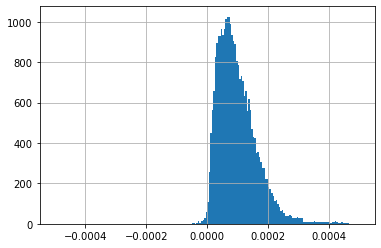

In [274]:
df_consolidado_2['a2'].hist(bins = 200, range = (-0.0005,0.0005))

<AxesSubplot:>

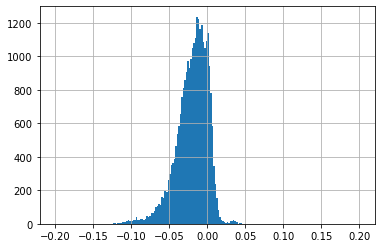

In [275]:
df_consolidado_2['a1'].hist(bins = 200, range = (-0.2,0.2))

<AxesSubplot:>

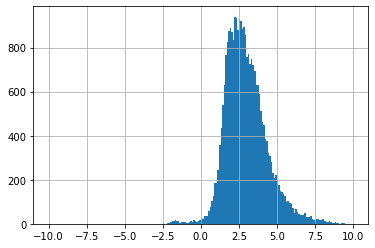

In [276]:
df_consolidado_2['a0'].hist(bins = 200, range = (-10,10))

<AxesSubplot:>

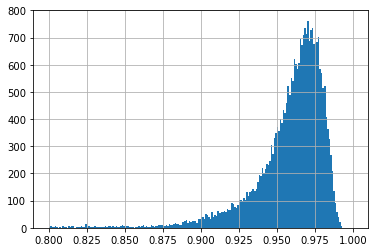

In [277]:
df_consolidado_2['r_value'].hist(bins = 200, range = (0.8,1))

<AxesSubplot:>

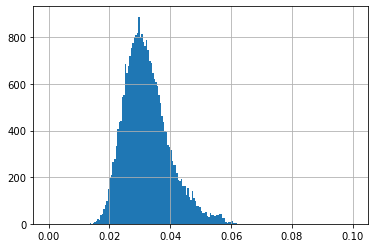

In [278]:
df_consolidado_2['std_err'].hist(bins = 200, range = (0,0.1))

In [279]:
df_consolidado_2 = df_consolidado.copy()

In [280]:
df_consolidado_2.columns

Index(['n_lavado', 'date_selected_start', 'date_selected_on',
       'date_selected_off', 'date_selected_finish', 'duracion_timestamp',
       'rpm_perfil', 'vib_1_mean', 'vib_2_mean', 'vib_1h_mean', 'vib_2h_mean',
       'vib_3h_mean', 'vib_4h_mean', 'flow_mean', 'vib_1_std', 'vib_2_std',
       'vib_1h_std', 'vib_2h_std', 'vib_3h_std', 'vib_4h_std', 'flow_std',
       'slope', 'intercept', 'r_value', 'p_value', 'std_err', 'a2', 'a1',
       'a0'],
      dtype='object')

In [281]:
df_consolidado_2['date_selected_start'] = pd.to_datetime(df_consolidado_2['date_selected_start'], errors = 'coerce')
df_consolidado_2['date_selected_finish'] = pd.to_datetime(df_consolidado_2['date_selected_finish'], errors = 'coerce')
df_consolidado_2['date_selected_on'] = pd.to_datetime(df_consolidado_2['date_selected_on'], errors = 'coerce')
df_consolidado_2['date_selected_off'] = pd.to_datetime(df_consolidado_2['date_selected_off'], errors = 'coerce')

In [282]:
df_consolidado_2['duracion_on'] = (df_consolidado_2['date_selected_on'] - df_consolidado_2['date_selected_start'])
df_consolidado_2['duracion_on'] = df_consolidado_2['duracion_on'].apply(lambda x: x.seconds/60)
df_consolidado_2['duracion_hold'] = (df_consolidado_2['date_selected_off'] - df_consolidado_2['date_selected_on'])
df_consolidado_2['duracion_hold'] = df_consolidado_2['duracion_hold'].apply(lambda x: x.seconds/60)
df_consolidado_2['duracion_off'] = (df_consolidado_2['date_selected_finish'] - df_consolidado_2['date_selected_off'])
df_consolidado_2['duracion_off'] = df_consolidado_2['duracion_off'].apply(lambda x: x.seconds/60)

<AxesSubplot:>

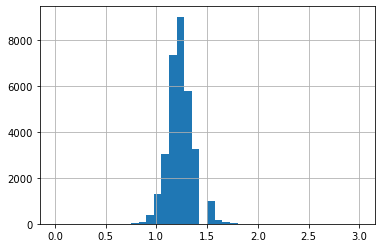

In [283]:
df_consolidado_2['duracion_on'].hist(bins = 40, range = (0, 3))

In [284]:
df_consolidado_2['duracion_on'].median()

1.25

<AxesSubplot:>

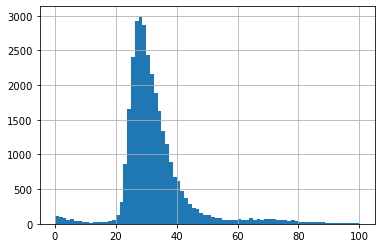

In [285]:
df_consolidado_2['duracion_hold'].hist(bins = 80, range = (0, 100))

In [286]:
df_consolidado_2['duracion_hold'].median()

30.416666666666668

In [287]:
df_consolidado_2['duracion_hold'].quantile(0.75) - df_consolidado_2['duracion_hold'].quantile(0.25)

8.583333333333336

In [288]:
1.348*df_consolidado_2['duracion_hold'].std()

23.50719368633939

<AxesSubplot:>

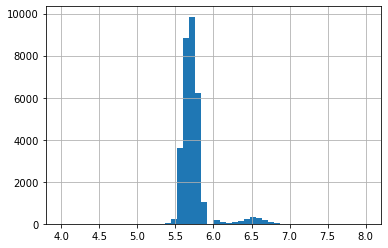

In [289]:
df_consolidado_2['duracion_off'].hist(bins = 50, range = (4, 8))

In [290]:
df_consolidado_2['duracion_off'].median()

5.75